In [1]:
#Import all the packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from scipy import ndimage
from ripser import ripser, lower_star_img
from persim import plot_diagrams 
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Rectangle
from joblib import dump, load
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Function to calculate Chi-distace 
def chi2_distance(A, B): 
    A=np.array(A)
    B=np.array(B)
    # compute the chi-squared distance
    chi=0
    for (a, b) in zip(A, B):
        if a != b:     
            chi=chi+((a - b) ** 2) / (a + b)
    chi=0.5*chi 
    return chi

#Some Common Functions to see the results

def print_results(X,y,model,type_data='test'):
    y_pred=model.predict(X)
    M=confusion_matrix(y,y_pred)#,normalize='all')
    M=pd.DataFrame(M,index=['True Other','True Van Gogh'],columns=['Pred. Other','Pred. Van Gog'])
    display(M)    
    print(('Score on '+type_data+' data: {:.2%}').format(model.score(X,y)))
    M2=confusion_matrix(y,y_pred,normalize='pred')
    print(('P[True Van|Pred Van]= {:.2%}').format(M2[1,1]))
    M3=confusion_matrix(y,y_pred,normalize='true')
    print(('P[Pred Van|True Van]= {:.2%}').format(M3[1,1]))

In [3]:
Catalog_train=pd.read_pickle('Catalogs/Catalog_train_w_strokes_and_channels_and_faces_and_hists.pkl')

In [12]:
#KNN On Ordered Histograms
X_train=np.array(list(Catalog_train.GNHist))
y_train=Catalog_train.Vangogh

knn=KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric = chi2_distance)
knn.fit(X_train,y_train)

#Save the New variable
Catalog_train['Pred_Hist']=knn.predict(X_train)

In [13]:
#Final Decision Tree combining all
final_tree=DecisionTreeClassifier(max_depth=4)
X_train=Catalog_train[['Pred_Hist','Mean_Strokes','No_Faces']]
   
final_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4)

In [14]:
#Fit the Test Data
Catalog_test=pd.read_pickle('Catalogs/Catalog_test_w_strokes_and_channels_and_faces_and_hists.pkl')

#New Variables from the models
Catalog_test['Pred_Hist']=knn.predict(np.array(list(Catalog_test.GNHist)))

In [15]:
#Finally predict!
print_results(Catalog_train[['Pred_Hist','Mean_Strokes','No_Faces']],Catalog_train.Vangogh,final_tree,'Final Train')
print_results(Catalog_test[['Pred_Hist','Mean_Strokes','No_Faces']],Catalog_test.Vangogh,final_tree,'Final Test')

,Pred. Other,Pred. Van Gog
True Other,754,46
True Van Gogh,76,184


Score on Final Train data: 88.49%
P[True Van|Pred Van]= 80.00%
P[Pred Van|True Van]= 70.77%


,Pred. Other,Pred. Van Gog
True Other,172,28
True Van Gogh,24,41


Score on Final Test data: 80.38%
P[True Van|Pred Van]= 59.42%
P[Pred Van|True Van]= 63.08%


In [16]:
Catalog_test['Final_Pred']=final_tree.predict(Catalog_test[['Pred_Hist','Mean_Strokes','No_Faces']])

In [19]:
#We are going to show some examples of the paintings that we could and couldn't predict
def plot_image(image,ax):
    b,g,r = cv2.split(image)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb

    ax.imshow(rgb_img)
    ax.set_xticks([]); ax.set_yticks([])   # to hide tick values on X and Y axis
    
def show_random_pictures(real,pred,data=Catalog_test,state=43202):
    images=list(data.loc[(data.Vangogh==real) & (data.Final_Pred==pred),['Image']].sample(4,random_state=state).Image)
    fig,axes=plt.subplots(2,2)
    axes=axes.ravel()
    for i in range(4):
        plot_image(images[i],axes[i])
    if real==1: 
        a='Van Gogh' 
    else: 
        a='Other'
    if pred==1: 
        b='Van Gogh' 
    else:
        b='Other'
    fig.suptitle(a+' predicted '+b)

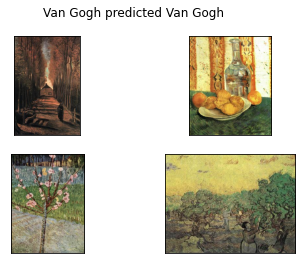

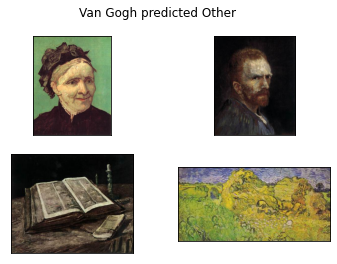

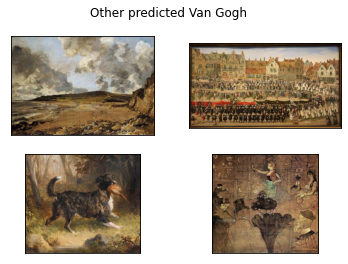

In [20]:
show_random_pictures(1,1)
show_random_pictures(1,0)
show_random_pictures(0,1)